In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("gdrive/Shared drives/Large Scale Analytics")
drive_path = "gdrive/Shared drives/Large Scale Analytics/"
model_lstm_path = 'lstm.h5'

In [0]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator
import pickle

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Load Data




In [0]:
XTrain = pd.read_pickle("./XTrain_Cleaned_hm_11_15.pkl")
XTest = pd.read_pickle("./XTest_Cleaned_hm_11_15.pkl")
yTrain = pd.read_pickle("./yTrain_prediction_11_15.pkl")
yTest = pd.read_pickle("./yTest_prediction_11_15.pkl")
cv_train = pd.read_pickle("./cv_train_CSR_Matrix_11_15.pkl")
cv_test = pd.read_pickle("./cv_test_CSR_Matrix_11_15.pkl")
csr_train = cv_train
csr_test = cv_test

## LSTM training

In [0]:
from keras.layers import Dense, Activation, Dropout, Embedding, SpatialDropout1D, LSTM
from keras import callbacks
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
pickle.dump(history, open('lstm_history.pkl', 'wb'))

Train on 81432 samples, validate on 9049 samples
Epoch 1/5
81432/81432 [==============================] - 583s 7ms/step - loss: 0.5522 - acc: 0.8069 - val_loss: 0.2638 - val_acc: 0.9060
Epoch 2/5
81432/81432 [==============================] - 583s 7ms/step - loss: 0.2117 - acc: 0.9260 - val_loss: 0.2099 - val_acc: 0.9241
Epoch 3/5
81432/81432 [==============================] - 587s 7ms/step - loss: 0.1410 - acc: 0.9499 - val_loss: 0.2185 - val_acc: 0.9214
Epoch 4/5
81432/81432 [==============================] - 598s 7ms/step - loss: 0.1072 - acc: 0.9610 - val_loss: 0.2097 - val_acc: 0.9249
Epoch 5/5
81432/81432 [==============================] - 597s 7ms/step - loss: 0.0861 - acc: 0.9690 - val_loss: 0.2307 - val_acc: 0.9224


In [0]:
model.save(model_lstm_path)

## Load the trained LSTM model


In [0]:
from keras.models import load_model
model = load_model(model_lstm_path)
history = pickle.load(open('lstm_history.pkl', 'rb'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))

10054/10054 [==============================] - 49s 5ms/step
Test set
  Loss: 0.224
  Accuracy: 0.927


In [0]:
# train_acc = model.evaluate(X_train, Y_train)
# test_acc = model.evaluate(X_test, Y_test)
# print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

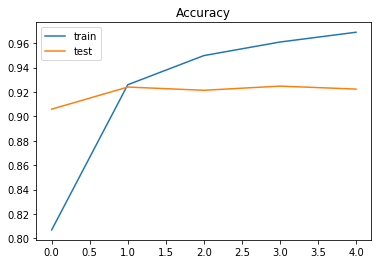

In [0]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

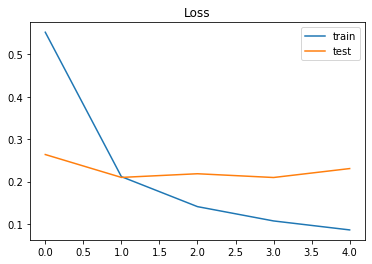

In [0]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [0]:
lstm_pred = model.predict(X_test)

In [0]:
lstm_pred.shape

(10054, 7)

In [0]:
print(Y_test.shape)
print(lstm_pred.shape)

(10054, 7)
(10054, 7)


In [0]:
lstm_predNum = [np.argmax(p) for p in lstm_pred]
Y_testNum = [np.argmax(p) for p in Y_test]
# lstm_predNum[:10]
# [1, 0, 1, 1, 3, 6, 3, 0, 0, 1]
print(len(lstm_predNum))
print(len(Y_testNum))

10054
10054


roc_auc:  0.5210072530233778


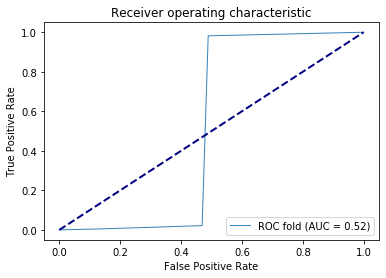

In [0]:
# print_roc(Y_testNum, lstm_predNum)
fpr, tpr, thresholds = roc_curve(Y_testNum, lstm_predNum, pos_label=1) #nb_predNum
roc_auc = auc(fpr, tpr)
print('roc_auc: ', roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC fold (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()